In [9]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
raw = rawpy.imread("IMG_4782.CR3")
array = np.array(raw.raw_image_visible)

In [10]:
np.max(array)

16383

In [11]:
np.min(array)

2029

In [12]:
array

array([[2362, 2513, 2332, ..., 2518, 2367, 2544],
       [2455, 2208, 2506, ..., 2218, 2513, 2237],
       [2381, 2419, 2393, ..., 2481, 2372, 2537],
       ...,
       [2193, 2110, 2163, ..., 2425, 2867, 2423],
       [2140, 2190, 2157, ..., 2798, 2727, 2863],
       [2222, 2101, 2190, ..., 2418, 2933, 2465]], dtype=uint16)

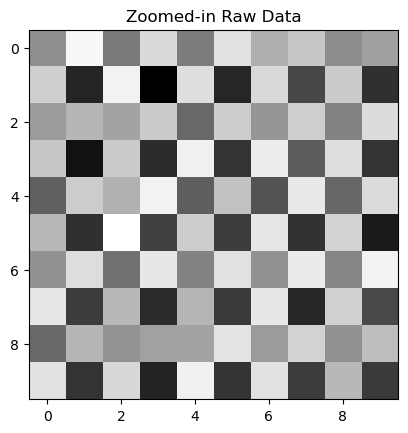

In [13]:
def inspect_bayer_pattern(raw_data):
    # Visualize a small part of the raw data
    plt.imshow(raw_data[:10, :10], cmap='gray')
    plt.title('Zoomed-in Raw Data')
    plt.show()
    # Add more sophisticated analysis as needed

raw_data = array
inspect_bayer_pattern(raw_data)

### Inspecting Bayer pattern by Analyzing RED

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt

# def inspect_bayer_pattern(raw_data):
#     # Visualize a small part of the raw data
#     plt.imshow(raw_data[2600:2610, 3800:3810], cmap='gray')
#     plt.title('Zoomed-in Raw Data')
#     plt.show()
#     # Add more sophisticated analysis as needed

# inspect_bayer_pattern(array)

In [15]:
from tqdm.auto import tqdm

### 3. Implement a Demosaicing Algorithm

In [16]:
import numpy as np
import cv2

def bilinear_demosaicing(raw_data):
    # Assuming raw_data is a numpy array of the RAW image data

    # Height and width of the raw image
    height, width = raw_data.shape

    # Create an empty image for the demosaiced output
    # This will be a 3-channel image for the RGB color space
    demosaiced_img = np.zeros((height, width, 3), dtype=np.uint16)

    # Bilinear demosaicing algorithm
    for row in tqdm(range(1, height - 1)):
        for col in range(1, width - 1):
            if (row % 2 == 1) and (col % 2 == 1):  # Blue pixel
                demosaiced_img[row, col, 0] = raw_data[row, col]  # Blue
                demosaiced_img[row, col, 1] = (raw_data[row, col - 1] + raw_data[row, col + 1] +
                                               raw_data[row - 1, col] + raw_data[row + 1, col]) // 4  # Green
                demosaiced_img[row, col, 2] = (raw_data[row - 1, col - 1] + raw_data[row - 1, col + 1] +
                                               raw_data[row + 1, col - 1] + raw_data[row + 1, col + 1]) // 4  # Red
            elif (row % 2 == 0) and (col % 2 == 0):  # Red pixel
                demosaiced_img[row, col, 0] = (raw_data[row - 1, col - 1] + raw_data[row - 1, col + 1] +
                                               raw_data[row + 1, col - 1] + raw_data[row + 1, col + 1]) // 4  # Blue
                demosaiced_img[row, col, 1] = (raw_data[row, col - 1] + raw_data[row, col + 1] +
                                               raw_data[row - 1, col] + raw_data[row + 1, col]) // 4  # Green
                demosaiced_img[row, col, 2] = raw_data[row, col]  # Red
            else:  # Green pixel
                demosaiced_img[row, col, 1] = raw_data[row, col]  # Green
                if row % 2 == 0:
                    demosaiced_img[row, col, 0] = (raw_data[row - 1, col] + raw_data[row + 1, col]) // 2  # Blue
                    demosaiced_img[row, col, 2] = (raw_data[row, col - 1] + raw_data[row, col + 1]) // 2  # Red
                     
                else:
                    demosaiced_img[row, col, 0] = (raw_data[row, col - 1] + raw_data[row, col + 1]) // 2  # Blue
                    demosaiced_img[row, col, 2] = (raw_data[row - 1, col] + raw_data[row + 1, col]) // 2  # Red


    return demosaiced_img


demosaiced_image = bilinear_demosaicing(array)


  0%|          | 0/4658 [00:00<?, ?it/s]

In [17]:
demosaiced_image[:,:,2]

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0, 2367, 2362, ..., 2383, 2369,    0],
       [   0, 2387, 2393, ..., 2403, 2372,    0],
       ...,
       [   0, 2144, 2158, ..., 2764, 2881,    0],
       [   0, 2148, 2157, ..., 2672, 2727,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [18]:
demosaiced_image = demosaiced_image[1:-1, 1:-1]

In [19]:
demosaiced_image.min()

2029

In [20]:
demosaiced_image.max()

16383

In [21]:
def map_to_255(image):
    # Assuming the image is in some range and you want to scale it to 0-255
    min_val = np.min(image)
    max_val = np.max(image)
    print("Max value:", max_val, "Min Value:", min_val)
    scaled_image = ((image - min_val) / (max_val - min_val)) * 255
    return scaled_image.astype(np.uint8)

demosaiced_image = map_to_255(demosaiced_image)

Max value: 16383 Min Value: 2029


In [22]:
demosaiced_image.min()

0

In [23]:
demosaiced_image.max()

255

In [24]:
output_path = 'bilinear_demosaicing_image.png'
cv2.imwrite(output_path, demosaiced_image)

True

### 4.Improve the Luminosity

In [25]:
gamma = 0.45
lower_percentile, upper_percentile = np.percentile(demosaiced_image, [0.01, 99.99])
normalized_image = (demosaiced_image - lower_percentile) / (upper_percentile - lower_percentile)
normalized_image[normalized_image < 0] = 0
normalized_image[normalized_image > 1] = 1

# Apply gamma correction
gamma_corrected_image = np.power(normalized_image, gamma)

# Invert normalization to get back to the original range
final_image = (gamma_corrected_image * (upper_percentile - lower_percentile)) + lower_percentile
final_image = np.clip(final_image, 0, 255).astype(np.uint8)

# Save the gamma corrected image
gamma_corrected_output_path = 'gamma_corrected_image_045.png'
cv2.imwrite(gamma_corrected_output_path, final_image)

True

### 5. White Balance

In [26]:
def apply_white_balance(img):
    # Calculate the average color of each RGB channel
    avg_r = np.mean(img[:,:,2])
    avg_g = np.mean(img[:,:,1])
    avg_b = np.mean(img[:,:,0])

    # Calculate the overall average color
    avg_gray = (avg_r + avg_g + avg_b) / 3

    # Scale each channel
    img[:,:,2] = np.clip((img[:,:,2] / avg_r) * avg_gray, 0, 255)
    img[:,:,1] = np.clip((img[:,:,1] / avg_g) * avg_gray, 0, 255)
    img[:,:,0] = np.clip((img[:,:,0] / avg_b) * avg_gray, 0, 255)

    return img.astype(np.uint8)

# Load the gamma-corrected image
gamma_corrected_image = cv2.imread(gamma_corrected_output_path)

# Apply white balance
white_balanced_image = apply_white_balance(gamma_corrected_image)

# Save the white balanced image
white_balanced_output_path = 'white_balanced_image_045.png'
cv2.imwrite(white_balanced_output_path, white_balanced_image)

True